In [ ]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 9.2MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 9.0MB/s 


In [ ]:
#!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1 -O erm.zip

--2021-03-03 12:57:15--  https://unirioja-my.sharepoint.com/:u:/g/personal/magarcd_unirioja_es/ERU6UfU2RGREnYNl_KxSpkkB4NP42bHj6siEIWrQ7aWPAQ?download=1
Resolving unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)... 13.107.136.9
Connecting to unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9TXgxYTMwUGUyRWc [following]
--2021-03-03 12:57:16--  https://unirioja-my.sharepoint.com/personal/magarcd_unirioja_es/Documents/erm.zip?originalPath=aHR0cHM6Ly91bmlyaW9qYS1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9tYWdhcmNkX3VuaXJpb2phX2VzL0VSVTZVZlUyUkdSRW5ZTmxfS3hTcGtrQjROUDQyYkhqNnNpRUlXclE3YVdQQVE_cnRpbWU9TXgxYTMwUGUyRWc
Reusing existing connection to unirioja-my.sharepo

In [ ]:
!unzip erm.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: erm/train/no/anonymized_1873542_fakeB.jpg  
  inflating: erm/train/no/anonymized_887511_fakeB.jpg  
  inflating: erm/train/no/anonymized_1351887_fakeB.jpg  
  inflating: erm/train/no/anonymized_1099051_fakeB.jpg  
  inflating: erm/train/no/anonymized_448602_fakeB.jpg  
  inflating: erm/train/no/anonymized_852019_fakeB.jpg  
  inflating: erm/train/no/anonymized_169973_fakeB.jpg  
  inflating: erm/train/no/anonymized_1241994_fakeB.jpg  
  inflating: erm/train/no/anonymized_1898489_fakeB.jpg  
  inflating: erm/train/no/anonymized_160483_fakeB.jpg  
  inflating: erm/train/no/anonymized_593874_fakeB.jpg  
  inflating: erm/train/no/anonymized_359235_fakeB.jpg  
  inflating: erm/train/no/anonymized_782889_fakeB.jpg  
  inflating: erm/train/no/anonymized_324102_fakeB.jpg  
  inflating: erm/train/no/anonymized_532397_fakeB.jpg  
  inflating: erm/train/no/anonymized_263513_fakeB.jpg  
  inflating: erm/train/no/anonymized_1

In [ ]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [ ]:
path = Path('erm/')
trainPath = path/'train'
testPath = path/'test'

In [ ]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [ ]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [ ]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnet_b2')
]

In [ ]:
import timm
timm.list_models('*efficientnet_b2*')

['efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'tf_efficientnet_b2',
 'tf_efficientnet_b2_ap',
 'tf_efficientnet_b2_ns']

In [ ]:
learn = timm_learner(dls512, 'efficientnet_b2',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=1.3182567499825382e-06)

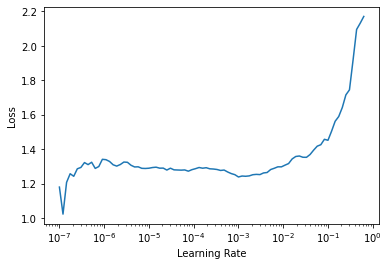

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.233940,1.027732,0.566081,0.568333,0.524615,00:54


Better model found at epoch 0 with valid_loss value: 1.027732491493225.


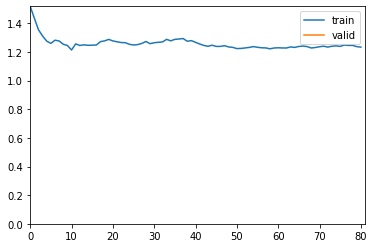

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.026515,0.900135,0.576012,0.599581,0.440000,01:00
1,0.951480,0.840836,0.572192,0.582721,0.487692,00:58


Better model found at epoch 0 with valid_loss value: 0.9001347422599792.


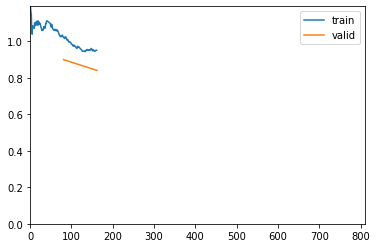

Better model found at epoch 1 with valid_loss value: 0.8408363461494446.


In [ ]:
learn.fine_tune(10,base_lr=1e-3)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

In [ ]:
learn.export(fname='efficientnet-B2.pkl')